In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [0]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import (
    FullyConnectedLayer, ReLULayer,
    ConvolutionalLayer, MaxPoolingLayer, Flattener,
    softmax_with_cross_entropy, l2_regularization
    )
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

In [0]:
def prepare_for_neural_network(train_X, test_X):    
    train_X = train_X.astype(np.float) / 255.0
    test_X = test_X.astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_X, axis = 0)
    train_X -= mean_image
    test_X -= mean_image
    
    return train_X, test_X
    
train_X, train_y, test_X, test_y = load_svhn("./data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)


Сверточный слой выполняет операцию свертки (convolution) с весами для каждого канала, а потом складывает результаты. 

http://cs231n.github.io/convolutional-networks/


In [0]:
X=train_X[:11]
X.shape

(11, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


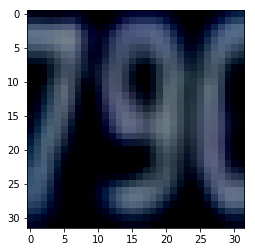

In [0]:
plt.imshow(X[0])

In [0]:


class ConvNet:
    """
    Implements a very simple conv net

    Input -> Conv[3x3] -> Relu -> Maxpool[4x4] ->
    Conv[3x3] -> Relu -> MaxPool[4x4] ->
    Flatten -> FC -> Softmax
    """
    def __init__(self, input_shape, n_output_classes, conv1_channels, conv2_channels):
        """
        Initializes the neural network

        Arguments:
        input_shape, tuple of 3 ints - image_width, image_height, n_channels
                                         Will be equal to (32, 32, 3)
        n_output_classes, int - number of classes to predict
        conv1_channels, int - number of filters in the 1st conv layer
        conv2_channels, int - number of filters in the 2nd conv layer
        """
        self.conv1_layer = ConvolutionalLayer(in_channels=input_shape[2], out_channels=conv1_channels,
                                              filter_size=3, padding=0)
        self.maxpool1_layer = MaxPoolingLayer(pool_size=4, stride=1) 
        self.conv2_layer = ConvolutionalLayer(in_channels=2, out_channels=conv2_channels,
                                              filter_size=3, padding=0)
        self.maxpool2_layer = MaxPoolingLayer(pool_size=4, stride=1) 
        self.flattener = Flattener()
        self.fc_layer = FullyConnectedLayer(968, 10)

    def compute_loss_and_gradients(self, X, y):
        """
        Computes total loss and updates parameter gradients
        on a batch of training examples

        Arguments:
        X, np array (batch_size, height, width, input_features) - input data
        y, np array of int (batch_size) - classes
        """
        # Before running forward and backward pass through the model,
        # clear parameter gradients aggregated from the previous pass

        # TODO Compute loss and fill param gradients

        for key in self.params().keys():
            self.params()[key].grad = 0.0

        conv1_out = self.conv1_layer.forward(X)
        maxpool1_out = self.maxpool1_layer.forward(conv1_out)
        conv2_out = self.conv2_layer.forward(maxpool1_out)
        maxpool2_out = self.maxpool2_layer.forward(conv2_out)
        flat = self.flattener.forward(maxpool2_out)
        fc_out = self.fc_layer.forward(flat)

        loss, grad = softmax_with_cross_entropy(fc_out, y)

        dfc_layer = self.fc_layer.backward(grad)
        dflat = self.flattener.backward(dfc_layer)
        dmaxpool2 = self.maxpool2_layer.backward(dflat)
        dconv2 = self.conv2_layer.backward(dmaxpool2)
        dmaxpool1 = self.maxpool1_layer.backward(dconv2)
        dconv1 = self.conv1_layer.backward(dmaxpool1)

        return loss

    def predict(self, X):
        conv1_out = self.conv1_layer.forward(X)
        maxpool1_out = self.maxpool1_layer.forward(conv1_out)
        conv2_out = self.conv2_layer.forward(maxpool1_out)
        maxpool2_out = self.maxpool2_layer.forward(conv2_out)
        flat = self.flattener.forward(maxpool2_out)
        fc_out = self.fc_layer.forward(flat)
        
        return fc_out.argmax(axis=1)

    def params(self):
        result = {}

        result['W_CONV1'] = self.conv1_layer.params()['W']
        result['B_CONV1'] = self.conv1_layer.params()['B']
        result['W_CONV2'] = self.conv2_layer.params()['W']
        result['B_CONV2'] = self.conv2_layer.params()['B']
        result['W_FC'] = self.fc_layer.params()['W']
        result['B_FC'] = self.fc_layer.params()['B']

        return result


In [0]:
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
dataset = Dataset(train_X[:16], train_y[:16], val_X[:16], val_y[:16])
trainer = Trainer(model, dataset, SGD(), batch_size=16, learning_rate=1e-3)

loss_history, train_history, val_history = trainer.fit()

Loss: 10.875467, Train accuracy: 0.187500, val accuracy: 0.062500
Loss: 10.567528, Train accuracy: 0.312500, val accuracy: 0.125000
Loss: 9.086109, Train accuracy: 0.187500, val accuracy: 0.125000
Loss: 10.708267, Train accuracy: 0.250000, val accuracy: 0.062500
Loss: 6.098072, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 2.961316, Train accuracy: 0.125000, val accuracy: 0.000000
Loss: 2.186610, Train accuracy: 0.187500, val accuracy: 0.000000
Loss: 2.025028, Train accuracy: 0.187500, val accuracy: 0.062500
Loss: 2.058356, Train accuracy: 0.187500, val accuracy: 0.000000
Loss: 2.102106, Train accuracy: 0.187500, val accuracy: 0.000000
Loss: 1.966976, Train accuracy: 0.187500, val accuracy: 0.000000
Loss: 1.934068, Train accuracy: 0.187500, val accuracy: 0.000000
Loss: 1.862469, Train accuracy: 0.250000, val accuracy: 0.000000
Loss: 1.834950, Train accuracy: 0.250000, val accuracy: 0.000000
Loss: 1.817584, Train accuracy: 0.250000, val accuracy: 0.000000
Loss: 1.811572, Train 

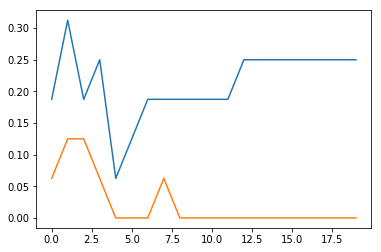

In [0]:
plt.plot(train_history)
plt.plot(val_history)

In [0]:
data_size = 128
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach 1.0 training accuracy in 50 epochs or less
# Hint: If you have hard time finding the right parameters manually, try grid search or random search!
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-3, num_epochs=50, batch_size=64)

loss_history, train_history, val_history = trainer.fit()

Loss: 6.148286, Train accuracy: 0.132812, val accuracy: 0.093750
Loss: 2.301060, Train accuracy: 0.132812, val accuracy: 0.093750
Loss: 2.296838, Train accuracy: 0.132812, val accuracy: 0.093750


KeyboardInterrupt: 

In [0]:
plt.plot(train_history)
plt.plot(val_history)